In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os 
os.chdir('/content/gdrive/My Drive/College/Semester 5/Soft Computing Lab/Lab - 8/')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import random

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
import os

In [ ]:
class Animator:
	'''
	An animator class only for animating 2D hyperboxes
	'''

	def __init__(self, box_history, train_patterns, classes, frame_rate, exp_bound, sensitivity,
				 filename='fuzzy_animation', verbose=True):
		# TODO: Customizable parameters
		assert len(box_history) == len(train_patterns), '{} (box-history) != {} (train_patterns)'.format(len(box_history), len(train_patterns))
		assert len(train_patterns[0][0]) == 2, 'Only 2D points are allowed.'

		self.fig = plt.figure()
		self.fig.set_dpi(100)
		self.fig.set_size_inches(7, 6.5)
		self.fig.suptitle('Fuzzy min-max classifier')
		if filename == '':
			filename = 'fuzzy_animation'
		self.filename = filename + '.mp4'
		self.box_history = box_history
		self.train_patterns = train_patterns
		self.classes = classes
		self.verbose = verbose

		self.frames = np.ravel(np.array([[i]*frame_rate for i in range(len(box_history))]))
		self.total = len(box_history)

		self.ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
		self.ax.set_title('θ = {} and γ = {}'.format(exp_bound, sensitivity))
		self.rectangles = []
		self.scatters = []
		self.colormap = [np.array([255, 0, 0]), np.array([0, 0, 255])] + [self.__get_random_color() for i in range(len(np.unique(classes)) - 2)]

		for i in range((len(train_patterns))):
			x, y = train_patterns[i]
			y = int(y)
			if y == 0:
				self.scatters.append(plt.scatter(-1, -1, c=tuple(self.colormap[y] / 255)))
			else:
				self.scatters.append(plt.scatter(-1, -1, c=tuple(self.colormap[y] / 255)))

		for _class in classes:
			if _class == 0:
				self.rectangles.append(plt.Rectangle((0, 0), 0, 0, fill=False, color='r')) 
			else:
				self.rectangles.append(plt.Rectangle((0, 0), 0, 0, fill=False, color='b'))

		if self.verbose:
			print('{:<20}: {:<10}'.format('Total Boxes', len(self.rectangles)))
			print('{:<20}: {:<10}'.format('Points to plot', len(self.scatters)))


	def __get_random_color(self):
		r = lambda: random.randint(0,255)
		return np.array([r(), r(), r()])


	def box_to_rect(self, box):
		vj, wj = box
		height = wj[1] - vj[1]
		width = wj[0] - vj[0]
		return tuple(vj), width, height


	def init(self):
		for i in self.rectangles:
			self.ax.add_patch(i)

		return tuple(self.rectangles) + tuple(self.scatters)


	def _animate(self, i):
		hyperboxes = self.box_history[i]
		# Plot training point
		x, y = self.train_patterns[i]
		self.scatters[i].set_offsets(tuple(x))
		for box in range(len(hyperboxes)):
			base, width, height = self.box_to_rect(hyperboxes[box])
			self.rectangles[box].set_xy(base)
			if width == 0:
				width = 0.02
			if height == 0:
				height = 0.02

			self.rectangles[box].set_width(width)
			self.rectangles[box].set_height(height)

		if self.verbose:
			print('{:<20}: {}/{}'.format('Animating frame', i+1, self.total), end='\r')

		return tuple(self.rectangles) + tuple(self.scatters)


	def animate(self):
		'''
		Main function to start animation
		'''

		anim = animation.FuncAnimation(self.fig, self._animate, 
							   init_func = self.init, 
							   frames = self.frames, 
							   interval = 20,
							   blit = True)

		anim.save(self.filename, fps=30, 
				  extra_args=['-vcodec', 'h264', 
							  '-pix_fmt', 'yuv420p'])

		if self.verbose:
			print('Animation complete! Video saved at {}'.format(os.path.join(os.getcwd(), self.filename)))


class FuzzyMMC:

	def __init__(self, sensitivity=1, exp_bound=1, animate=False):
		'''
		Constructor for FuzzyMMC class
		'''
		self.sensitivity = sensitivity
		self.hyperboxes = None
		self.isanimate = animate
		self.classes = np.array([])
		self.exp_bound = exp_bound

		if self.animate:
			self.box_history = []
			self.train_patterns = []


	def membership(self, pattern):
		'''
		Calculates membership values a pattern
		
		Returns an ndarray of membership values of all hyperboxes
		'''
		min_pts = self.hyperboxes[:, 0, :]
		max_pts = self.hyperboxes[:, 1, :]
		
		a = np.maximum(0, (1 - np.maximum(0, (self.sensitivity * np.minimum(1, pattern - max_pts)))))
		b = np.maximum(0, (1 - np.maximum(0, (self.sensitivity * np.minimum(1, min_pts - pattern)))))

		return np.sum(a + b, axis=1) / (2 * len(pattern))


	def overlap_contract(self, index):
		'''
		Check if any classwise dissimilar hyperboxes overlap
		'''
		contracted = False
		for test_box in range(len(self.hyperboxes)):

			if self.classes[test_box] == self.classes[index]:
				# Ignore same class hyperbox overlap
				continue
	
			expanded_box = self.hyperboxes[index]
			box = self.hyperboxes[test_box]

			## TODO: Refactor for vectorization
			vj, wj = expanded_box
			vk, wk = box

			delta_new = delta_old = 1
			min_overlap_index = -1
			for i in range(len(vj)):
				if vj[i] < vk[i] < wj[i] < wk[i]:
					delta_new = min(delta_old, wj[i] - vk[i])

				elif vk[i] < vj[i] < wk[i] < wj[i]:
					delta_new = min(delta_old, wk[i] - vj[i])

				elif vj[i] < vk[i] < wk[i] < wj[i]:
					delta_new = min(delta_old, min(wj[i] - vk[i], wk[i] - vj[i]))

				elif vk[i] < vj[i] < wj[i] < wk[i]:
					delta_new = min(delta_old, min(wj[i] - vk[i], wk[i] - vj[i]))

				if delta_old - delta_new > 0:
					min_overlap_index = i
					delta_old = delta_new

			if min_overlap_index >= 0:
				i = min_overlap_index
				# We need to contract the expanded box
				if vj[i] < vk[i] < wj[i] < wk[i]:
					vk[i] = wj[i] = (vk[i] + wj[i])/2

				elif vk[i] < vj[i] < wk[i] < wj[i]:
					vj[i] = wk[i] = (vj[i] + wk[i])/2

				elif vj[i] < vk[i] < wk[i] < wj[i]:
					if (wj[i] - vk[i]) > (wk[i] - vj[i]):
						vj[i] = wk[i]

					else:
						wj[i] = vk[i]

				elif vk[i] < vj[i] < wj[i] < wk[i]:
					if (wk[i] - vj[i]) > (wj[i] - vk[i]):
						vk[i] = wj[i]

					else:
						wk[i] = vj[i]

				self.hyperboxes[test_box] = np.array([vk, wk])
				self.hyperboxes[index] = np.array([vj, wj])
				contracted = True

		return contracted



	def train_pattern(self, X, Y):
		'''
		Main function that trains a fuzzy min max classifier
		Note:
		Y is a one-hot encoded target variable
		'''
		target = Y
		
		if target not in self.classes:
			
			# Create a new hyberbox
			if self.hyperboxes is not None:
				self.hyperboxes = np.vstack((self.hyperboxes, np.array([[X, X]])))
				self.classes = np.hstack((self.classes, np.array([target])))

			else:
				self.hyperboxes = np.array([[X, X]])
				self.classes = np.array([target])

			if self.isanimate:
				self.box_history.append(np.copy(self.hyperboxes))
				self.train_patterns.append((X, Y))
		else:
			
			memberships = self.membership(X)
			memberships[np.where(self.classes != target)] = 0
			memberships = sorted(list(enumerate(memberships)), key=lambda x: x[1], reverse=True)
			
			# Expand the most suitable hyperbox
			count = 0
			while True:
				index = memberships[count][0]
				min_new = np.minimum(self.hyperboxes[index, 0, :], X)
				max_new = np.maximum(self.hyperboxes[index, 1, :], X)
				
				if self.exp_bound * len(np.unique(self.classes)) >= np.sum(max_new - min_new):
					self.hyperboxes[index, 0] = min_new
					self.hyperboxes[index, 1] = max_new
					break
				else:
					count += 1

				if count == len(memberships):
					self.hyperboxes = np.vstack((self.hyperboxes, np.array([[X, X]])))
					self.classes = np.hstack((self.classes, np.array([target])))
					index = len(self.hyperboxes) - 1
					break

			# Overlap test
			if self.isanimate:
				self.box_history.append(np.copy(self.hyperboxes))
				self.train_patterns.append((X, Y))

			contracted = self.overlap_contract(index)
			
			if self.isanimate and contracted:	
				self.box_history.append(np.copy(self.hyperboxes))
				self.train_patterns.append((X, Y))


	def fit(self, X, Y):
		'''
		Wrapper for train_pattern
		'''
		for x, y in zip(X, Y):
			self.train_pattern(x, y)


	def predict(self, X):
		'''
		Predict the class of the pattern X
		'''
		classes = np.unique(self.classes)
		results = []
		memberships = self.membership(X)
		max_prediction = 0
		pred_class = 0
		for _class in classes:
			mask = np.zeros((len(self.hyperboxes),))
			mask[np.where(self.classes == _class)] = 1
			p = memberships * mask
			prediction, class_index = np.max(p), np.argmax(p)
			if prediction > max_prediction:
				max_prediction = prediction
				pred_class = class_index

		return max_prediction, self.classes[pred_class] 


	def score(self, X, Y):
		'''
		Scores the classifier
		'''
		count = 0
		for x, y in zip(X, Y):
			_, pred = self.predict(x)
			if y == pred:
				count += 1

		return count / len(Y)


	def animate(self, frame_rate=10, filename='', verbose=True):
		'''
		To make a video of the classifier training.
		NOTE: Only possible when working with 2 dimensional patterns
		'''
		if self.isanimate:
			animator = Animator(box_history=self.box_history,
								train_patterns=self.train_patterns,
								classes=self.classes,
								frame_rate=frame_rate,
								exp_bound=self.exp_bound,
								sensitivity=self.sensitivity,
								filename=filename,
								verbose=verbose)

			animator.animate()

			return animator.filename

		else:
			raise Exception('No animation data was collected! Create a fuzzy classifier instance with animate=True')


if __name__ == "__main__":

	patterns = np.array([[0.1, 0.1],
						 [0.6, 0.6],
						 [0.5, 0.5],
						 [0.4, 0.3]])

	classes = np.array([0, 1, 0, 1])

	df = pd.read_csv('iris.csv', header=None, names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])

	df = df[~(df['class']=='Iris-virginica')]

	df.head()

	df.replace(to_replace='Iris-setosa', value=0, inplace=True)

	df.replace(to_replace='Iris-versicolor', value=1, inplace=True)

	df = df.sample(frac=1)

	X_train = df[['sepal length', 'petal length']].values
	Y_train = df['class'].values

	_max = np.max(X_train, axis=0)
	_min = np.min(X_train, axis=0)
	X_train = (X_train - _min) / (_max - _min)

## Iris dataset

In [ ]:
df = pd.read_csv('iris.csv', header=None, names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])

df = df[~(df['class']=='Iris-virginica')]

df.head()

df.replace(to_replace='Iris-setosa', value=0, inplace=True)

df.replace(to_replace='Iris-versicolor', value=1, inplace=True)

df = df.sample(frac=1)

X_train = df[['sepal length', 'petal length']].values
Y_train = df['class'].values

_max = np.max(X_train, axis=0)
_min = np.min(X_train, axis=0)
X_train = (X_train - _min) / (_max - _min)

X_test, Y_test = X_train[-20:], Y_train[-20:]
X_train, Y_train = X_train[:-20], Y_train[:-20]

In [ ]:
X_train.shape, Y_train.shape

((80, 2), (80,))

In [ ]:
clf2 = FuzzyMMC(sensitivity=1, exp_bound=0.1, animate=True)

In [ ]:
clf2.fit(X_train, Y_train)

In [ ]:
clf2.score(X_test, Y_test)

1.0

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Total Boxes         : 17        
Points to plot      : 88        
Animation complete! Video saved at /content/gdrive/My Drive/College/Semester 5/Soft Computing Lab/Lab - 8/fuzzy_animation.mp4


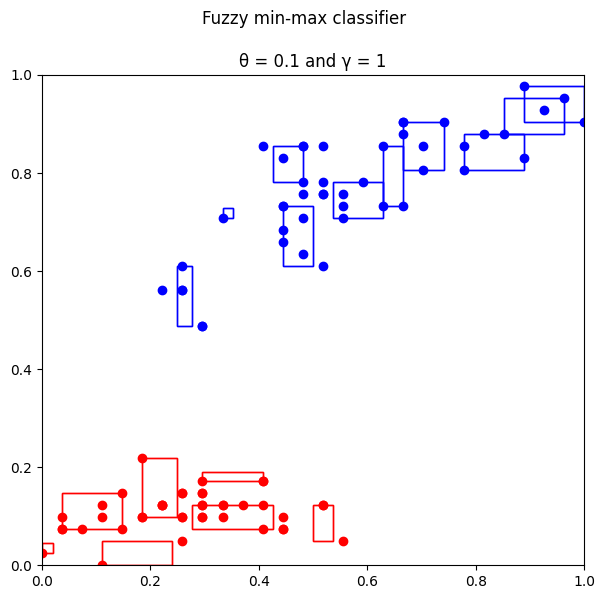

In [ ]:
_ = clf2.animate()

In [ ]:
import io
import base64
from IPython.display import HTML

video = io.open('fuzzy_animation.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

## Generated dataset

In [ ]:
def rand_uniform(x, y):
    return random.random() * (y- x) + x

def gen_circle(num_samples):
    num_samples = num_samples
    radius = 5
    points = []
    noise = 0.5
    
    def get_label(x, y):
        dist = math.sqrt(x ** 2 + y ** 2)
        return 0 if dist < radius * 0.5 else 1
    
    for i in range(num_samples//2):
        r = rand_uniform(0, radius * 0.5)
        angle = rand_uniform(0, 2 * math.pi)
        x = r * math.sin(angle)
        y = r * math.cos(angle)
        noiseX = rand_uniform((-1)*radius, radius) * noise
        noiseY = rand_uniform((-1)*radius, radius) * noise
        #label = get_label(noiseX, noiseY)
        label = 0
        points.append((x, y, label))
    
    for i in range(num_samples // 2):
        r = rand_uniform(radius * 0.7, radius)
        angle = rand_uniform(0, 2 * math.pi)
        x = r * math.sin(angle)
        y = r * math.cos(angle)
        noiseX = rand_uniform((-1)*radius, radius) * noise
        noiseY = rand_uniform((-1)*radius, radius) * noise
        #label = get_label(noiseX, noiseY)
        label = 1
        points.append((x, y, label))
        
    return points

In [ ]:
o = gen_circle(100)
o = np.array(o)
train = pd.DataFrame(o)

In [ ]:
train_x = []
train_y = []
np.random.shuffle(o)
for i in o:
    train_x.append([i[0], i[1]])
    train_y.append(i[2])

train_x = np.array(train_x)
train_y = np.array(train_y)
_max = np.max(train_x, axis=0)
_min = np.min(train_x, axis=0)
train_x = (train_x - _min) / (_max - _min)
train_x.shape, train_y.shape

((100, 2), (100,))

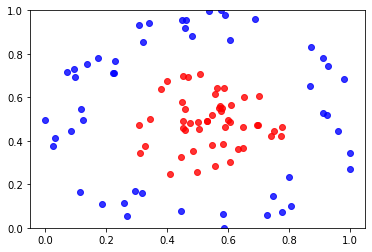

In [ ]:
for x, y in zip(train_x, train_y):
    if y == 0:
        plt.scatter(x[0], x[1], c='r', alpha=0.8)
    else:
        plt.scatter(x[0], x[1], c='b', alpha=0.8)
plt.ylim([0, 1])
plt.show()

In [ ]:
a = FuzzyMMC(sensitivity=1, exp_bound=0.7, animate=True)

In [ ]:
a.fit(train_x, train_y)

In [ ]:
a.score(train_x, train_y)

0.67

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Total Boxes         : 2         
Points to plot      : 164       
Animation complete! Video saved at /content/gdrive/My Drive/College/Semester 5/Soft Computing Lab/Lab - 8/fuzzy_animation.mp4


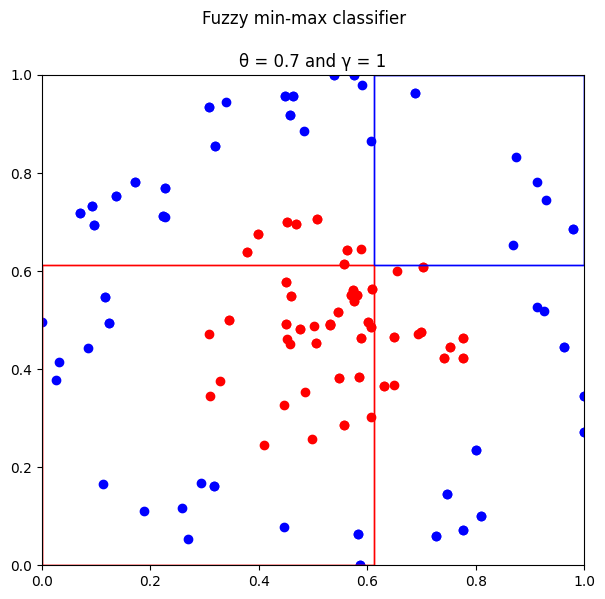

In [ ]:
_ = a.animate(frame_rate=5)

In [ ]:
import io
import base64
from IPython.display import HTML

video = io.open('./fuzzy_animation.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))